In [ ]:
# all the code can be download at: 
# 

## input data: extracted CHILI ifs data ( Newton:/share/data/chili/DRP/)
    
## Output: reconstrcted 2D waveband image of CHILI


# 1. load data

### input 数据说明：经过空间方向抽谱的 wavelength(fitting parameters), 和 flux(pixel index, intenstiy)数据。
https://social.shao.ac.cn/wikis/home?lang=zh-cn#!/wiki/CHILI/page/%E6%AC%A2%E8%BF%8E%E8%BF%9B%E5%85%A5%20CHILI

tmp2017****

    raw_data/

         all .list files and fits files you needed

         _readme: some of the fits file included here are revised for the test run. (see below)

    output/

         -- ptow*.dat

            5 cols, the wavelength solution, a0,a1,a2,a3,a4

            lanmda=a0+a1*x+a2*x^2+a3*x^3+a4*x^4, x is the x axsis pixel position

        -- mask*.dat

           the new fiber position after extraction (but before collapse).

        -- spectrums fits files (including science & standard stars)

           blue side: b1 (124 fibers) & b2 (123 fibers)

           red side:  b3 (122 fibers) & b4 (123 fibers)

            -- *pefsmc.fits

               the final collapsed spectra (flux uncalibrated). -666 for dead fiber.

            -- *pefsm.fits， *pefw.fits

               the final spectra and its error before collapse, which are files needed by "chili_cube.pro"
               
               
### wavelength(fitting parameters)--> *ptwbi.fits (i = 1,2,3,4)
### flux(pixel index, intenstiy)--> *bipefsmc.fits (i = 1,2,3,4)

# lens array 
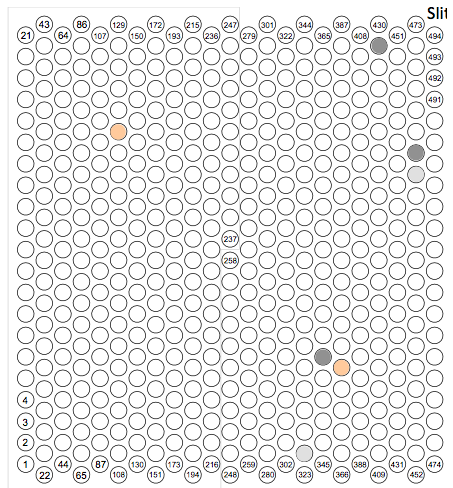

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
from astropy.io import fits
import turtle as t
import math as m

def loading_and_shown(dir0,wv1,wv2,fn):
    dir0 = dir0
    wv1 = wv1
    wv2 = wv2
    fn = fn
    list0 = os.listdir(dir0)
    print(list0)
    
    fp=open(dir0 + list0[4])
    p2wb1 = fp.readlines()                  # p2wb1: Photon to wave b1                        
    fp=open(dir0 + list0[5])
    p2wb2 = fp.readlines()
    fp=open(dir0 + list0[6])
    p2wb3 = fp.readlines()
    fp=open(dir0 + list0[7])
    p2wb4 = fp.readlines()
    
    # open the fits file and shown one frame data.
    b1 = fits.open(dir0 + list0[0])
    b2 = fits.open(dir0 + list0[1])
    b3 = fits.open(dir0 + list0[2])
    b4 = fits.open(dir0 + list0[3])
    b1s = b1[0].data                        # b1s: b1 spectrum
    b2s = b2[0].data
    b3s = b3[0].data
    b4s = b4[0].data
    
    m1,n1 = b1s.shape
    wvb1 = np.zeros((n1))           # wvb1: wavelength of b1
    wbfb1 = np.zeros((m1))            # wbfb1: wave band flux b1
    m2,n2 = b2s.shape
    wbfb2 = np.zeros((m2))            # wbfb1: wave band flux b1
    m3,n3 = b3s.shape
    wbfb3 = np.zeros((m3))            # wbfb1: wave band flux b1
    m4,n4 = b4s.shape
    wbfb4 = np.zeros((m4))            # wbfb1: wave band flux b1            
    wvb1,wbfb1 = get_wbfbi(b1s,p2wb1)
    wvb2,wbfb2 = get_wbfbi(b2s,p2wb2)
    wvb3,wbfb3 = get_wbfbi(b3s,p2wb3)
    wvb4,wbfb4 = get_wbfbi(b4s,p2wb4)
    wbfb3[27] = wbfb3[27+1]
    wbfb3[64] = wbfb3[64+1]
    wbfb4[101] = wbfb4[101+1]
    
    plt.figure(num = 'im_show')
    plt.subplot(411)
    plt.imshow(b1s,cmap='gray')
    plt.title('b1-spectrum')
    plt.subplot(412)
    plt.imshow(b2s,cmap='gray')
    plt.title('b2-spectrum')
    plt.subplot(413)
    plt.imshow(b3s,cmap='gray')
    plt.title('b3-spectrum')
    plt.subplot(414)
    plt.imshow(b4s,cmap='gray')
    plt.title('b4-spectrum')

    plt.figure(num = 'sp_show fiber: fn = 15')
    plt.subplot(221)
    plt.plot(wvb1, b1s[fn,:])
    plt.title('b1-spectrum')
    plt.subplot(222)
    plt.plot(wvb2, b2s[fn,:])
    plt.title('b2-spectrum')
    plt.subplot(223)
    plt.plot(wvb4, b4s[fn,:])
    plt.title('b4-spectrum')
    plt.subplot(224)
    plt.plot(wvb4, b4s[fn,:])
    plt.title('b5-spectrum')
    
    plt.figure(num = 'waveband flux shown')
    plt.subplot(221)
    plt.plot(wbfb1)
    plt.title('b1-wabebandflux')
    plt.subplot(222)
    plt.plot(wbfb2)
    plt.title('b2-wabebandflux')
    plt.subplot(223)
    plt.plot(wbfb3)
    plt.title('b3-wabebandflux')
    plt.subplot(224)
    plt.plot(wbfb4)
    plt.title('b4-wabebandflux')
    
    return wvb1,wvb2,wvb3,wvb4,wbfb1,wbfb2,wbfb3,wbfb4 

def get_waveband_flux(wv,fx,wv1,wv2):
    if wv[0] > wv2:
        waveband_flux = 0
        #print('waveband red has no data!')
    elif wv[-1] < wv1:
        waveband_flux = 0
        #print('waveband blue has no data!')
    elif np.sum(fx) == 0:
        waveband_flux = 0
    else:
        index1 = np.where(wv > wv1)
        mi = index1[0][0]
        index2 = np.where(wv < wv2)
        ma = index2[0][-1]
        waveband_flux = np.sum(fx[mi:ma])
    return waveband_flux

def get_wbfbi(bis,p2wbi):
    pindex = np.linspace(0,2063,2064) # pindex: pixel index
    wvbi = np.zeros((2064))           # wvb1: wavelength of b1
    m,n = bis.shape
    wbfbi = np.zeros((m))            # wbfb1: wave band flux b1
    for i in range(m):
        w1 = p2wbi[i]
        a0 = float(w1[1:16])
        a1 = float(w1[17:32])
        a2 = float(w1[33:46])
        a3 = float(w1[47:61])
        a4 = float(w1[62:76])
        wvbi = a0 + a1 * pindex + a2 * pindex**2 + a3 * pindex**3 + a4 * pindex**4  # WAVE 
        fxbi = bis[i,:]
        #print('fiber',i,wv1,'to',wv2,'waveband flux is:', get_waveband_flux(wvbi,fxbi,wv1,wv2))
        if np.sum(fxbi) <= 0:
            print('###################### bad fiber! ################')
        elif wvbi[0] > wv2:
            print('###################### waveband red has no data! ################')
        elif wvbi[-1] < wv1:
            print('###################### waveband red has no data! ################')
        wbfbi[i] = get_waveband_flux(wvbi,fxbi,wv1,wv2)
    #print('b',i,' data percessing over') 
    return wvbi,wbfbi

wvb1,wbfb1 = get_wbfbi(b1s,p2wb1)
wvb2,wbfb2 = get_wbfbi(b2s,p2wb2)
wvb3,wbfb3 = get_wbfbi(b3s,p2wb3)
wvb4,wbfb4 = get_wbfbi(b4s,p2wb4)
wbfb3[27] = wbfb3[27+1]
wbfb3[64] = wbfb3[64+1]
wbfb4[101] = wbfb4[101+1]

###################### bad fiber! ################
###################### bad fiber! ################
###################### bad fiber! ################


Text(0.5, 1.0, 'b4-spectrum')

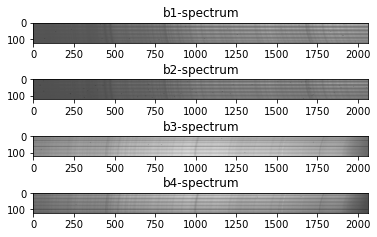

In [19]:
plt.figure(num = 'im_show')
plt.subplot(411)
plt.imshow(b1s,cmap='gray')
plt.title('b1-spectrum')
plt.subplot(412)
plt.imshow(b2s,cmap='gray')
plt.title('b2-spectrum')
plt.subplot(413)
plt.imshow(b3s,cmap='gray')
plt.title('b3-spectrum')
plt.subplot(414)
plt.imshow(b4s,cmap='gray')
plt.title('b4-spectrum')

######################################################
# 2. rerange
# matching the waveband flux number to the 2D lens array
# waveband flux of b2 and b3 have been fliped.
# original: b1/b2: from center to margin, b3/b4:from margin to center
# then, b2: from margin to center 1:123
#       b1: from center to margin  124:247
#       b4: from margin to center 248:370
#       b3: from center to margin 371:494

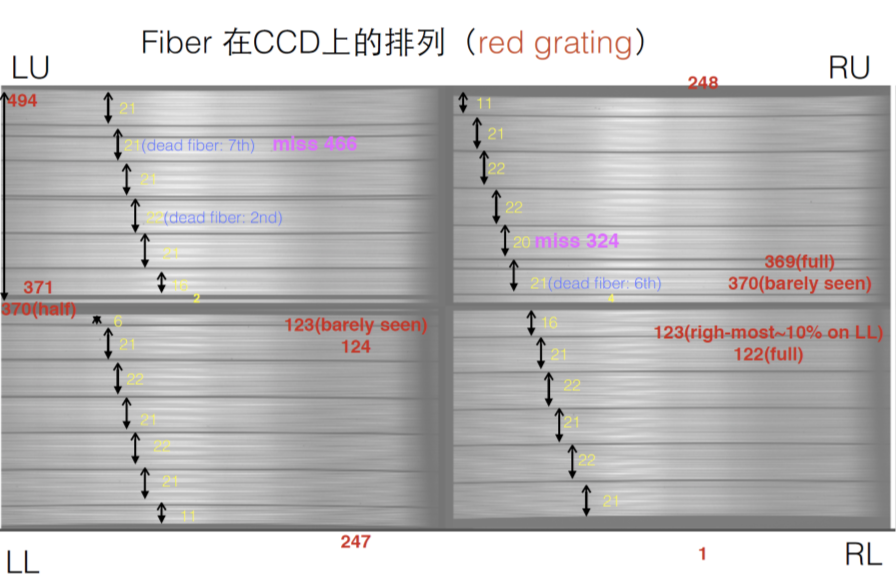


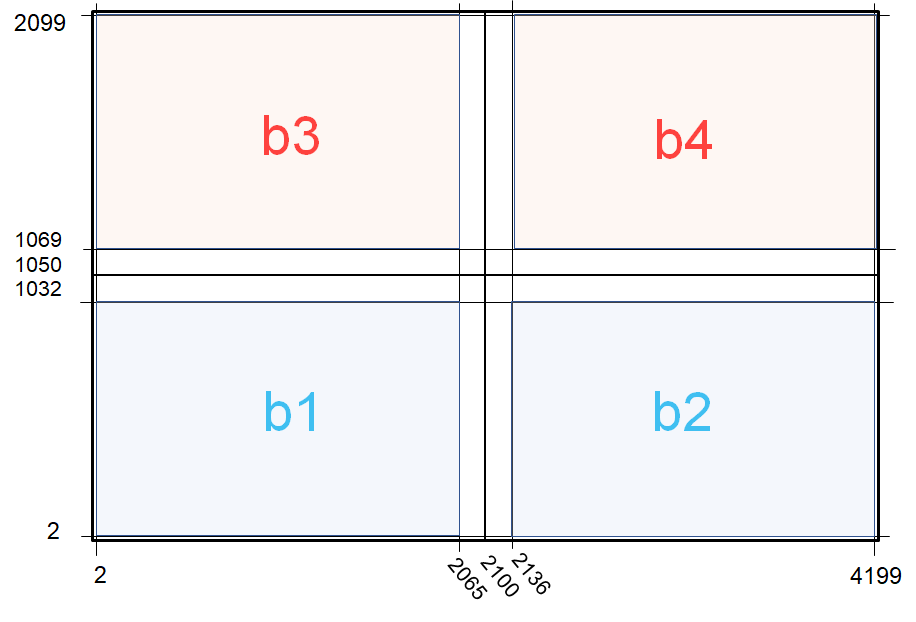

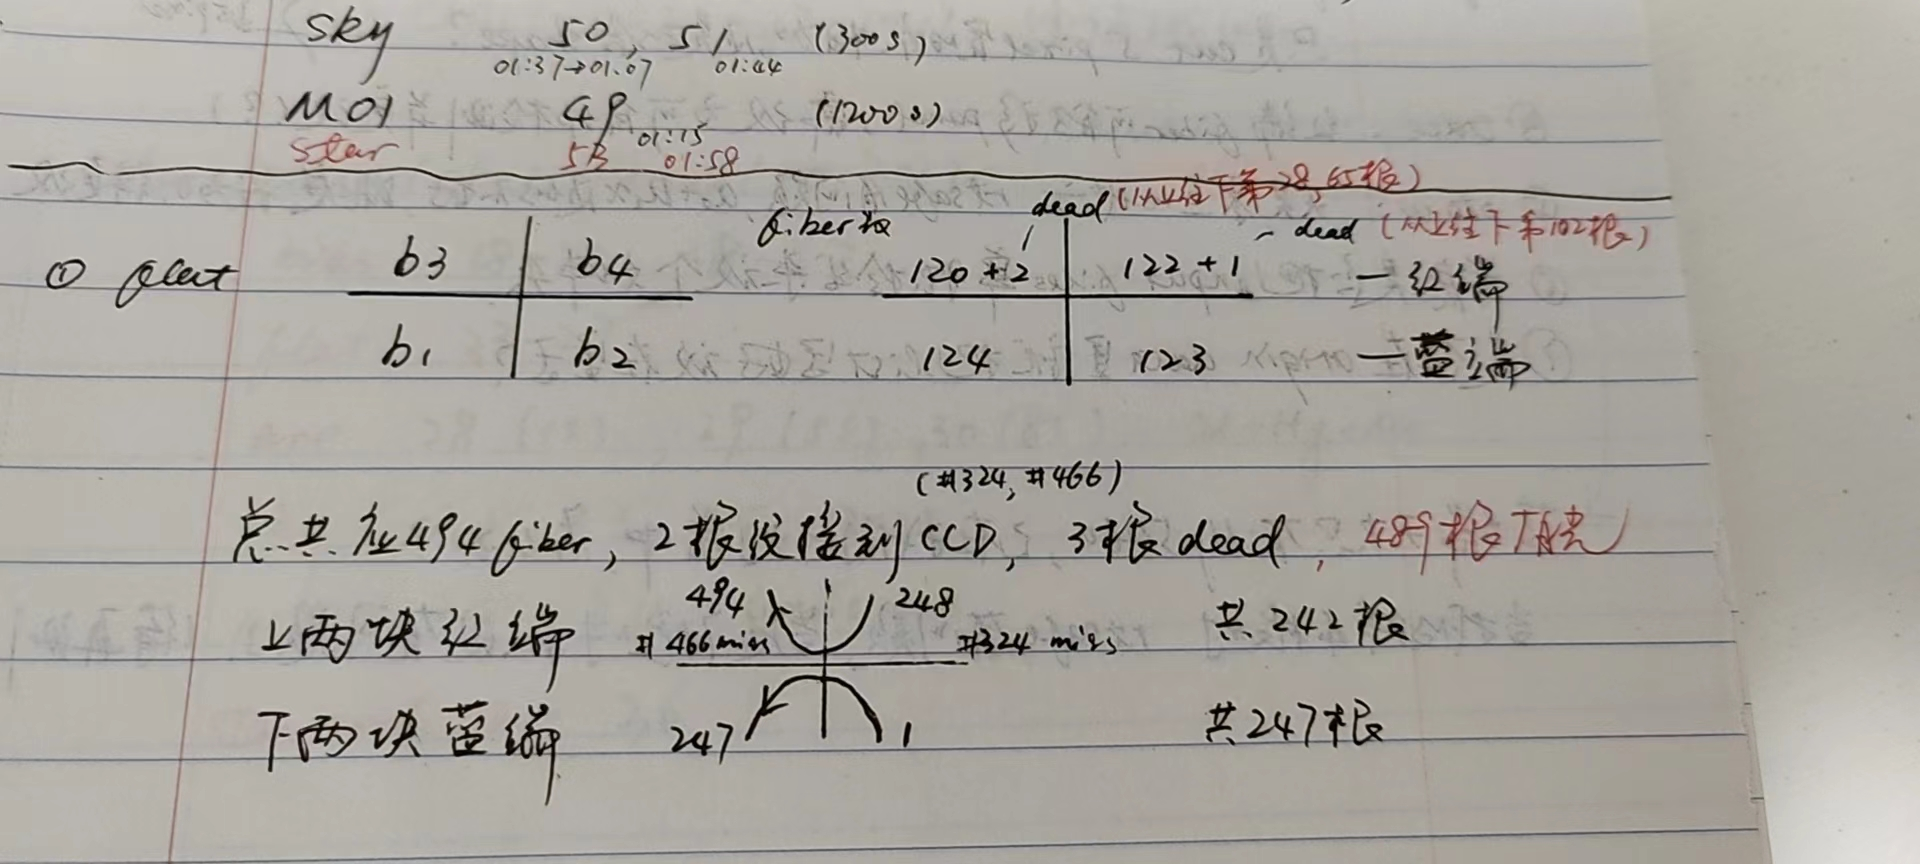

In [20]:
def rearrange(wbfb1,wbfb2,wbfb3,wbfb4):
    wbfb2 =wbfb2[::-1]
    wbfb3 =wbfb3[::-1]
# =============================================================================
#     wbfb3 =wbfb3[::-1]
#     wbfb4 =wbfb4[::-1]
# =============================================================================
    
    wbf = np.zeros(([23,22]))
    wbfb = np.zeros(([23,22]))
    wbfr = np.zeros(([23,22]))
    #whole image(blue + red)
    wbf[0,0:21]=wbfb2[0:21]             # python strat form 0, number -1
    wbf[1,0:22]=wbfb2[21:43]
    wbf[2,0:21]=wbfb2[43:64]
    wbf[3,0:22]=wbfb2[64:86]
    wbf[4,0:21]=wbfb2[86:107]
    wbf[5,0:16]=wbfb2[107:123]
    wbf[5,16:22]=wbfb1[0:6]
    wbf[6,0:21] = wbfb1[6:27]
    wbf[7,0:22] = wbfb1[27:49]
    wbf[8,0:21] = wbfb1[49:70]
    wbf[9,0:22] = wbfb1[70:92]          # N9： 173-193
    wbf[10,0:21] = wbfb1[92:113]
    wbf[11,0:11] = wbfb4[0:11]
    wbf[11,11:22] = wbfb1[123:112:-1]
    wbf[12,0:21] = wbfb4[11:32]
    wbf[13,0:22] = wbfb4[32:54]
    wbf[14,0:21] = wbfb4[54:75]         # N14： 280-301
    wbf[15,0:22] = wbfb4[75:97]
    wbf[16,0:21] = wbfb4[97:118]
    wbf[17,0:5] = wbfb4[118:123]        # N17: 366-387
    wbf[17,5:22] = wbfb3[0:17]
    wbf[18,0:21] = wbfb3[17:38]
    wbf[19,0:22] = wbfb3[38:60]
    wbf[20,0:21] = wbfb3[60:81]
    wbf[21,0:22] = wbfb3[81:103]
    wbf[22,0:19] = wbfb3[103:122] 
    # blue band
    wbfb[0,0:21]=wbfb2[0:21]             # python strat form 0, number -1
    wbfb[1,0:22]=wbfb2[21:43]
    wbfb[2,0:21]=wbfb2[43:64]
    wbfb[3,0:22]=wbfb2[64:86]
    wbfb[4,0:21]=wbfb2[86:107]
    wbfb[5,0:16]=wbfb2[107:123]
    wbfb[5,16:22]=wbfb1[0:6]
    wbfb[6,0:21] = wbfb1[6:27]
    wbfb[7,0:22] = wbfb1[27:49]
    wbfb[8,0:21] = wbfb1[49:70]
    wbfb[9,0:22] = wbfb1[70:92]          # N9： 173-193
    wbfb[10,0:21] = wbfb1[92:113]
    wbfb[11,11:22] = wbfb1[123:112:-1]
    # red band
    wbfr[11,0:11] = wbfb4[0:11]
    wbfr[12,0:21] = wbfb4[11:32]
    wbfr[13,0:22] = wbfb4[32:54]
    wbfr[14,0:21] = wbfb4[54:75]         # N14： 280-301
    wbfr[15,0:22] = wbfb4[75:97]
    wbfr[16,0:21] = wbfb4[97:118]
    wbfr[17,0:5] = wbfb4[118:123]        # N17: 366-387
    wbfr[17,5:22] = wbfb3[0:17]
    wbfr[18,0:21] = wbfb3[17:38]
    wbfr[19,0:22] = wbfb3[38:60]
    wbfr[20,0:21] = wbfb3[60:81]
    wbfr[21,0:22] = wbfb3[81:103]
    wbfr[22,0:19] = wbfb3[103:122]
    print('rearranging over')
    
    plt.figure(num = 'waveband flux rearrange')
    plt.subplot(221)
    plt.plot(wbfb1)
    plt.title('b1-wabebandflux')
    plt.subplot(222)
    plt.plot(wbfb2)
    plt.title('b2-wabebandflux')
    plt.subplot(223)
    plt.plot(wbfb3)
    plt.title('b3-wabebandflux')
    plt.subplot(224)
    plt.plot(wbfb4)
    plt.title('b4-wabebandflux')
    
    return wbf, wbfb, wbfr   # waveband flux, waveband flux blue, waveband flux red.

# 3. reconstruction 

## 有了wv1-wv2 wavaband 的flux,根据rearrange的结果重构出二维空间分布结果。

# wv1,wv2: 输入感兴趣的波段范围：  
    ## if wv1 > blue band 的最大值，则提示 blue band 没有数据
    ## if wv2 < red band 的最小值，则提示 red band 没有数据
    ## 对于异常fiber ,赋值其周围的光纤
# dir0: 输入*. *ptwbi.fits (i = 1,2,3,4)； *bipefsmc.fits 数据
# fn: 想要抽取显示的某根光纤的光谱（显示四根光纤光谱：b1(fn),b2(fn),b3(fn),b4(fn),）


['chilia0120034b1pefsmc.fits', 'chilia0120034b2pefsmc.fits', 'chilia0120034b3pefsmc.fits', 'chilia0120034b4pefsmc.fits', 'ptowb1_chilia170120.dat', 'ptowb2_chilia170120.dat', 'ptowb3_chilia170120.dat', 'ptowb4_chilia170120.dat']
###################### bad fiber! ################
###################### bad fiber! ################
###################### bad fiber! ################


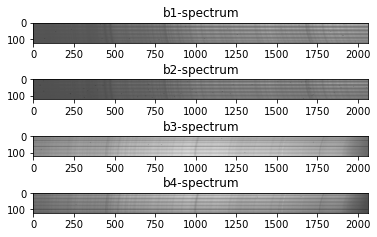

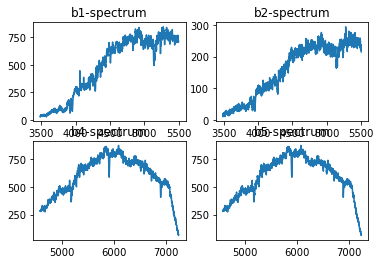

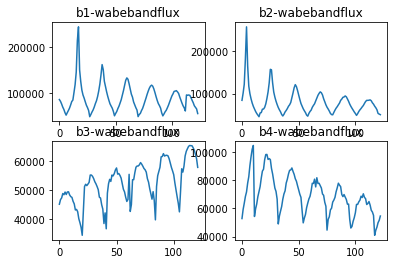

In [35]:
wv1 = 4950
wv2 = 5150

# 1.2 load data loacation
dir0 = r'C:\Users\DELL\OneDrive - EDU A1\git-code\github\chili_reconstruction\sp\120034/'

# 1.3 chosing the fiber number for showing the IFS spectrum
fn = 15

wvb1,wvb2,wvb3,wvb4,wbfb1,wbfb2,wbfb3,wbfb4 = loading_and_shown(dir0,wv1,wv2,fn)  

rearranging over


Text(0.5, 1.0, 'b5-spectrum')

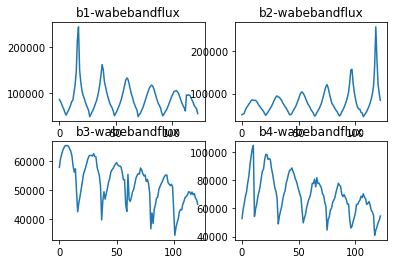

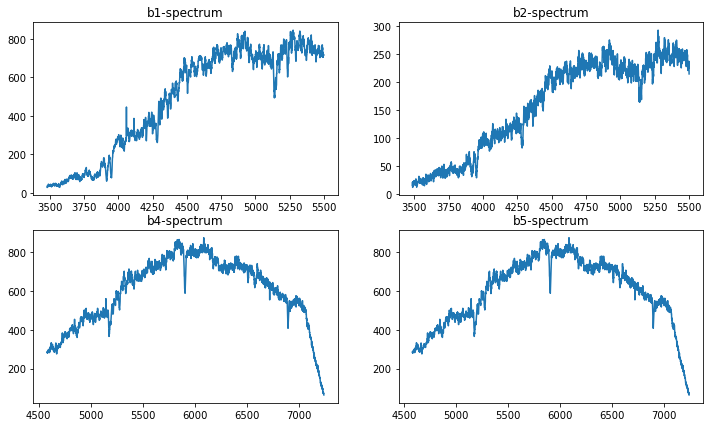

In [36]:
# 2. rearranging          
wbf,wbfb,wbfr = rearrange(wbfb1,wbfb2,wbfb3,wbfb4)           # wvb1: wavelength of b1
plt.figure(figsize = [12,7],num = 'sp_show fiber: fn = 15')
plt.subplot(221)
plt.plot(wvb1, b1s[fn,:])
plt.title('b1-spectrum')
plt.subplot(222)
plt.plot(wvb2, b2s[fn,:])
plt.title('b2-spectrum')
plt.subplot(223)
plt.plot(wvb4, b4s[fn,:])
plt.title('b4-spectrum')
plt.subplot(224)
plt.plot(wvb4, b4s[fn,:])
plt.title('b5-spectrum')         

max,min,mean of waveband red for showing is: 1.0 3.904863849600264e-06 0.1602333349849904
max,min,mean of waveband red for showing is: 1.0 9.534388154476157e-06 0.28209960682884816
max,min,mean of whole image for showing is: 1.0000095343881545 1.3439252004076421e-05 0.4423329418138386
2D mapping over.


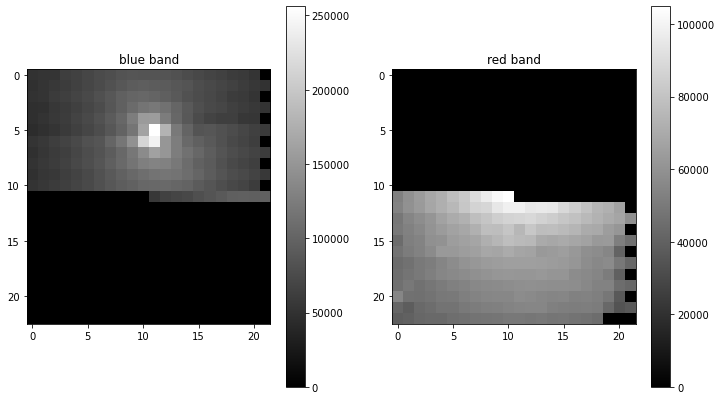

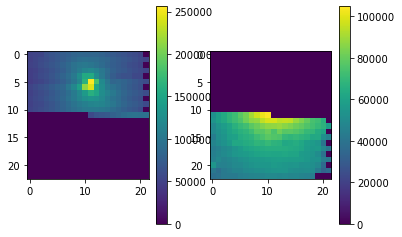

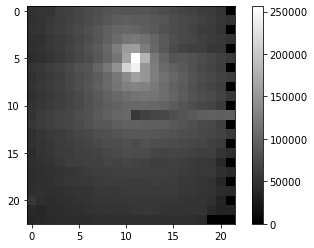

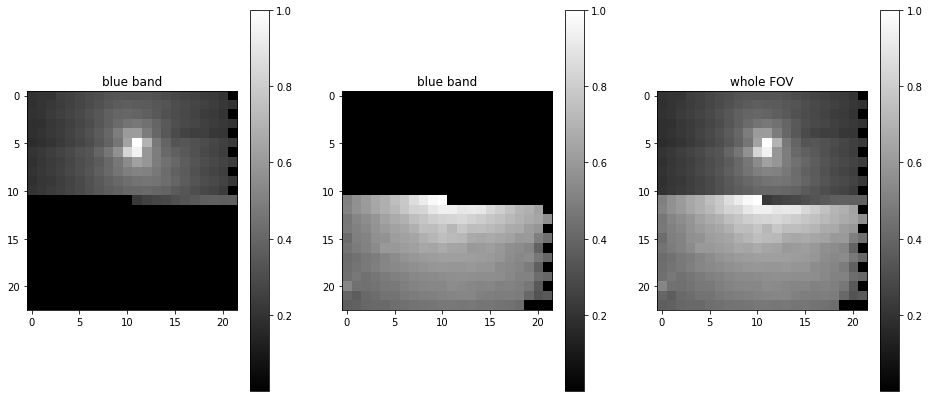

In [37]:
# 2D MAPPING
def mapping_chili_ifs(wbf,wbfb,wbfr):
    mfb = np.max(wbfb)
    mfr = np.max(wbfr)
    plt.figure(figsize = [12,7],num = 'waveband flux shown4')
    plt.subplot(121)
    plt.imshow(wbfb,cmap='gray')#,vmin = 0.95*mfb, vmax = mfb)
    plt.title('blue band')
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(wbfr,cmap='gray')#,vmin = 0.95*mfr, vmax = mfr)
    plt.title('red band')
    plt.colorbar()
    
    plt.figure(num = 'waveband flux shown6')
    plt.subplot(121)
    plt.imshow(wbfb)#,vmin = 0.8*mfb, vmax = mfb)
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(wbfr)#,vmin = 0.8*mfr, vmax = mfr)
    plt.colorbar()
    
    plt.figure(num = 'waveband flux shown5')
    plt.imshow(wbf,cmap='gray')#,vmin = 0.8*mfb, vmax = mfr)
    plt.colorbar()
    
    wbfbs = wbfb
    wbfrs = wbfr
    indexb = np.where(wbfbs == 0)
    wbfbs[indexb] = 1.0
    wbfbs[0,21] = 1.0
    wbfbs[2,21] = 1.0
    wbfbs[4,21] = 1.0
    wbfbs[6,21] = 1.0
    wbfbs[8,21] = 1.0
    wbfbs[10,21] = 1.0
    mfbs = np.max(wbfbs)
    wbfbs1 = wbfb / mfbs  # waveband flux of blue for shown
    wbfbs = wbfbs1 #* 20
    print('max,min,mean of waveband red for showing is:',np.max(wbfbs),np.min(wbfbs),np.mean(wbfbs))
 
    indexr = np.where(wbfrs == 0)
    wbfrs[indexr] = 1.0
    wbfrs[12,21] = 1.0
    wbfrs[14,21] = 1.0
    wbfrs[16,21] = 1.0
    wbfrs[18,21] = 1.0
    wbfrs[20,21] = 1.0
    wbfrs[22,19:22] = 1.0
    mfrs = np.max(wbfrs)
    wbfrs1 = wbfr / mfrs  # waveband flux of blue for shown
    wbfrs = wbfrs1 #* 20
    print('max,min,mean of waveband red for showing is:',np.max(wbfrs),np.min(wbfrs),np.mean(wbfrs))
    
    wbfs = wbfbs + wbfrs
    
    index = np.where(wbfs > 1.01)
    wbfs[index] += - 1.0
    index = np.where(wbfs < 0)
    wbfs[index] = 0
    print('max,min,mean of whole image for showing is:',np.max(wbfs),np.min(wbfs),np.mean(wbfs))
    
    plt.figure(figsize = [16,7],num = 'waveband flux shown 10')
    plt.subplot(131)
    plt.imshow(wbfbs,cmap='gray')
    plt.title('blue band')
    plt.colorbar()
    plt.subplot(132)
    plt.imshow(wbfrs,cmap='gray')
    plt.title('blue band')
    plt.colorbar()
    plt.subplot(133)
    plt.imshow(wbfs,cmap='gray')
    plt.title('whole FOV')
    plt.colorbar()
    
    return wbfbs,wbfrs,wbfs

# 3. mapping
wbfbs,wbfrs,wbfs = mapping_chili_ifs(wbf, wbfb, wbfr)
print('2D mapping over.')

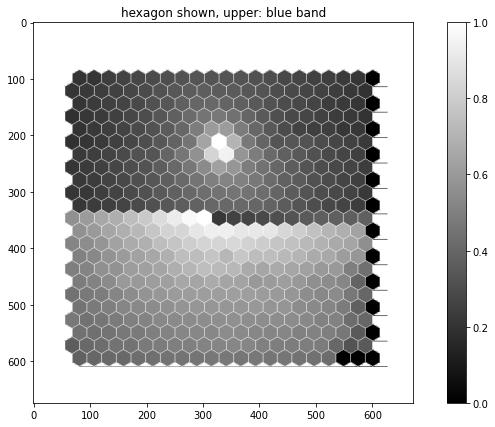

In [33]:
def draw_hexagon(band): 
    import turtle as t
    cr = 20
    t.pencolor(1.,1.,1.)                                        #以图形中心点为基准进行绘图扩张
    t.setup(900,900,0,0)
    for y in range(23):                              #设置列向第一个图形的坐标
        pen_y =300 -30 *y
        pen_x =-350 + 5 *m.sqrt(3) *m.pow(-1,y)
        t.penup()
        t.goto(pen_x,pen_y)
        t.pendown
        for x in range(22):                          #设置行向图形的扩张
            t.begin_fill()
            t.fillcolor(band[y,x],band[y,x],band[y,x])
            t.circle(cr,steps=6)
            x1 =pen_x + cr *m.sqrt(3) *x
            t.penup()
            t.setx(x1)
            t.pendown()
            t.end_fill() 
    
def hexagon_show():
    from PIL import Image
    import skimage.io as io 
    image_eps = 'whole.eps'
    im = Image.open(image_eps)
    mim = np.max(im)
    mmim = im / mim
    plt.figure(figsize = [12,7],num = 'hexagon shown')
    plt.imshow(mmim,cmap='gray')
    plt.title('hexagon shown, upper: blue band')
    plt.colorbar()

t.tracer(False)                                      
draw_hexagon(wbfs)
img = t.getscreen()
img.getcanvas().postscript(file= "whole.eps")
t.bye()
hexagon_show()

In [ ]:
print('CHILI reconstrction over!')